# Scraped Fixtures API Example

## Run this example in [Colab](https://signaloceansdk.github.io/SignalSDK/examples/jupyter/ScrapedFixturesAPI/Scraped%20Fixtures%20API%20Example/)

Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [1]:
signal_ocean_api_key = '' # Replace with your subscription key

# Scraped Fixtures API

The goal of Scraped Fixtures API is to collect and return scraped fixtures by the given filters or fixture IDs. This can be done by using the `ScrapedFixturesAPI` class and calling appropriate methods


#### 1. Request by filters

Fixtures can be retrieved for specific filters, by calling the `get_fixtures` method with the following arguments:

#### Required

`vessel_type` The vessel type

_Additionally, at least one of the following is required_

`imos` List of IMOs

`received_date_from` Earliest date the fixture received

`received_date_to` Latest date the fixture received

`updated_date_from` Earliest date the fixture updated

`updated_date_to` Latest date the fixture updated

> Mixing received and updated dates is not allowed

> It's highly recommended to use UTC  dates, since this is the internally used format


#### 2. Request by fixture IDs

Fixtures can be retrieved for specific fixture IDs, by calling the `get_fixtures_by_fixture_ids` method with the following argument:

#### Required

`fixture_ids` A list of fixture ids to retrieve

### Additional optional arguments

Both methods, also accept the following optional arguments:

`include_details` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
parsed_part_id, line_from, line_to, in_line_order, source
```

`include_scraped_fields` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
scraped_vessel_name, scraped_deadweight, scraped_year_built, scraped_laycan, scraped_load, scraped_load2, scraped_discharge, scraped_discharge_options, scraped_discharge2, scraped_charterer, scraped_cargo_type, scraped_quantity, scraped_rate, scraped_rate_options, scraped_delivery_date, scraped_delivery, scraped_redelivery_from, scraped_redelivery_to
```

`include_vessel_details` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
vessel_name, deadweight, year_built, liquid_capacity, vessel_type_id, vessel_type, vessel_class, commercial_operator_id, commercial_operator
```

`include_labels` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
load_name, load_taxonomy, load_name2, load_taxonomy2, discharge_name, discharge_taxonomy, discharge_name2, discharge_taxonomy2, charterer, cargo_type, cargo_group, open_geo_name, open_taxonomy, delivery_name, delivery_taxonomy, redelivery_from_name, redelivery_from_taxonomy, redelivery_to_name, redelivery_to_taxonomy, charter_type, fixture_status
```

`include_content` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
content
```

`include_sender` If this field is `True` the following columns will be included in the response (otherwise they will be `None`): 
```
sender
```

`include_debug_info` If this field is `True` the following columns will be included in the response (otherwise they will be `None`):
```
is_private, is_invalidated, is_partial
```

> Default value is `True` for the arguments described above 

## Installation

To install _Signal Ocean SDK_, simply run the following command

In [2]:
%%capture
%pip install signal-ocean

## Quickstart

Import `signal-ocean` and other modules required for this demo

In [3]:
from signal_ocean import Connection
from signal_ocean.scraped_fixtures import ScrapedFixturesAPI

from datetime import datetime, timedelta
import pandas as pd
import plotly.graph_objects as go

Create a new instance of the `ScrapedFixturesAPI` class

In [4]:
connection = Connection(signal_ocean_api_key)
api = ScrapedFixturesAPI(connection)

Now you are ready to retrieve your data

#### Request by date

To get all tanker fixtures received the last twelve hours, you must declare appropriate `vessel_type` and `received_date_from` variables

In [5]:
vessel_type = 1  # Tanker
received_date_from = datetime.utcnow() - timedelta(hours=12)

And then call `get_fixtures` method, as below

In [6]:
scraped_fixtures = api.get_fixtures(
    vessel_type = vessel_type,
    received_date_from = received_date_from,
)

next(iter(scraped_fixtures), None)

ScrapedFixture(fixture_id=94921010, message_id=26333331, parsed_part_id=41760392, line_from=84, line_to=84, in_line_order=1, source='Email', updated_date=datetime.datetime(2022, 8, 3, 22, 0, 24, tzinfo=datetime.timezone.utc), received_date=datetime.datetime(2022, 8, 3, 21, 58, 52, tzinfo=datetime.timezone.utc), is_deleted=False, scraped_vessel_name='silver dover', scraped_deadweight=None, scraped_year_built=None, imo=9692337, vessel_name='Silver Dover', deadweight=49635, year_built=2015, liquid_capacity=54247, vessel_type_id=1, vessel_type='Tanker', vessel_class_id=88, vessel_class='MR2', commercial_operator_id=1482, commercial_operator='Shell', scraped_laycan='04-05', laycan_from=datetime.datetime(2022, 8, 4, 0, 0, tzinfo=datetime.timezone.utc), laycan_to=datetime.datetime(2022, 8, 5, 0, 0, tzinfo=datetime.timezone.utc), scraped_load='usg', load_geo_id=24676, load_name='US Gulf', load_taxonomy_id=4, load_taxonomy='Level0', scraped_load2=None, load_geo_id2=None, load_name2=None, load_t

For better visualization, it's convenient to insert data into a DataFrame

In [7]:
df = pd.DataFrame(scraped_fixtures)

df.head()

,fixture_id,message_id,parsed_part_id,line_from,line_to,in_line_order,source,updated_date,received_date,is_deleted,...,charter_type,fixture_status_id,fixture_status,is_owners_option,is_coa,content,sender,is_private,is_invalidated,is_partial
0,94921010,26333331,41760392,84,84,1.0,Email,2022-08-03 22:00:24+00:00,2022-08-03 21:58:52+00:00,False,...,Voyage,1.0,FullyFixed,False,False,silver dover 38ulsd usg caribs/peru/chile $1.9...,Clarksons,True,False,False
1,94921011,26333331,41760392,72,72,0.0,Email,2022-08-03 22:00:24+00:00,2022-08-03 21:58:52+00:00,False,...,Voyage,0.0,OnSubs,False,False,sti mayfair 38ulsd usg ta-waf w375-w475 07 che...,Clarksons,True,False,False
2,94921012,26333331,41760392,85,85,NaN,Email,2022-08-03 22:00:24+00:00,2022-08-03 21:58:52+00:00,False,...,Voyage,1.0,FullyFixed,False,False,apollon oo 38ums+ulsd usg manaus $3.625m 04-06...,Clarksons,True,False,False
3,94921013,26333331,41760392,80,80,NaN,Email,2022-08-03 22:00:24+00:00,2022-08-03 21:58:52+00:00,False,...,Voyage,1.0,FullyFixed,False,False,bastille street tuxapn 06 fxd,Clarksons,True,False,True
4,94921014,26333331,41760392,77,77,NaN,Email,2022-08-03 22:00:24+00:00,2022-08-03 21:58:52+00:00,False,...,Voyage,1.0,FullyFixed,False,False,sea cougar pozos 02 fxd,Clarksons,True,False,True


#### Request by IMOs

To get fixtures for specific vessel(s) by their IMO number(s), you can simple call the `get_fixtures` method for a list of desired IMO(s)

In [8]:
imos = df.imo.dropna().sample(5, replace=True).astype(int).tolist()  # Or add a list of your desired fixture IDs

imos

[9845697, 9892444, 9877559, 9746061, 9761358]

Adding some date argument is always feasible

In [9]:
scraped_fixtures_by_imos = api.get_fixtures(
    vessel_type=vessel_type,
    received_date_from=received_date_from,
    imos=imos,
)

df_by_imos = pd.DataFrame(scraped_fixtures_by_imos)
df_by_imos.head()

,fixture_id,message_id,parsed_part_id,line_from,line_to,in_line_order,source,updated_date,received_date,is_deleted,...,charter_type,fixture_status_id,fixture_status,is_owners_option,is_coa,content,sender,is_private,is_invalidated,is_partial
0,94929477,26340088,41765983,50,50,NaN,Email,2022-08-04 03:44:30+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,0.0,OnSubs,False,False,sanana 35 ums muara/spore 13-15/08 600k petroc...,Eastport Maritime,True,False,False
1,94929485,26340088,41765983,54,54,NaN,Email,2022-08-04 03:44:30+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,1.0,FullyFixed,False,False,eco los angeles 30 cpp pengerang/japan dnr rnr...,Eastport Maritime,True,False,False
2,94929492,26340088,41765983,49,49,NaN,Email,2022-08-04 03:44:30+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,2.0,Failed,False,False,sanana 35 cpp spore/colombo 10-12/08 950k turb...,Eastport Maritime,True,False,False
3,94933262,26343077,41768106,119,119,NaN,Email,2022-08-04 05:10:09+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,0.0,OnSubs,False,False,None,Eastport Maritime,True,False,True
4,94933757,26343079,41768108,41,41,NaN,Email,2022-08-04 05:10:24+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,0.0,OnSubs,False,False,None,Eastport Maritime,True,False,True


#### Request by fixutre IDs

In the same manner, to get data for specific fixtures ID(s), you must call the `get_fixtures_by_fixture_ids` method for a list of desired fixture ID(s)

In [10]:
fixture_ids = df.sample(5, replace=True).fixture_id.tolist()  # Or add a list of your desired fixture IDs

fixture_ids

[94928545, 94923913, 94933278, 94928217, 94944388]

Date arguments are not available in `get_fixtures_by_fixture_ids` method

In [11]:
scraped_fixtures_by_ids = api.get_fixtures_by_fixture_ids(
    fixture_ids = fixture_ids,
)

df_by_ids = pd.DataFrame(scraped_fixtures_by_ids)
df_by_ids.head()

,fixture_id,message_id,parsed_part_id,line_from,line_to,in_line_order,source,updated_date,received_date,is_deleted,...,charter_type,fixture_status_id,fixture_status,is_owners_option,is_coa,content,sender,is_private,is_invalidated,is_partial
0,94933278,26343077,41768106,18,18,None,Email,2022-08-04 05:10:09+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,0.0,OnSubs,False,False,None,Eastport Maritime,True,False,True
1,94944388,26353875,41776524,71,71,None,Email,2022-08-04 08:04:30+00:00,2022-08-04 00:00:00+00:00,False,...,Voyage,NaN,None,False,False,sti jermyn 75 nap 12/aug ag/japan ws240 bp,Intermodal,True,False,False
2,94923913,26334296,41761312,32,32,None,Email,2022-08-04 00:39:05+00:00,2022-08-04 00:37:25+00:00,False,...,Voyage,NaN,None,False,False,ptt 80 nhc sts linggi thailand 10-12/aug eagle...,SSY,True,False,False
3,94928217,26339208,41765363,23,23,None,Email,2022-08-04 03:22:05+00:00,2022-08-04 03:19:19+00:00,False,...,Voyage,NaN,None,False,False,aegean myth 80 nhc 23 / aug zirku / mangalore ...,Taipan Shipbrokers,True,False,False
4,94928545,26339572,41765634,39,39,None,Email,2022-08-04 03:32:06+00:00,2022-08-04 03:31:23+00:00,False,...,Voyage,NaN,None,False,True,c. progress 12 fuja 18/aug on hold no details,BRS Baxi,True,False,True


#### Usage of optional arguments

By default, all fields are returned. This is convenient in many cases, for example to compare scraped and mapped fields

In [12]:
fields_to_display = [
    'scraped_vessel_name',
    'vessel_name',
    'scraped_quantity',
    'quantity',
    'scraped_charterer',
    'charterer',
    'scraped_laycan',
    'laycan_from',
    'laycan_to',
]

df[fields_to_display].head()

,scraped_vessel_name,vessel_name,scraped_quantity,quantity,scraped_charterer,charterer,scraped_laycan,laycan_from,laycan_to
0,silver dover,Silver Dover,38,38000.0,turbo asia,Turbo Asia,04-05,2022-08-04 00:00:00+00:00,2022-08-05 00:00:00+00:00
1,sti mayfair,STI Mayfair,38,38000.0,chevron,Chevron,07,2022-08-07 00:00:00+00:00,2022-08-07 00:00:00+00:00
2,apollon,Apollon,38,38000.0,atem,Atem,04-06,2022-08-04 00:00:00+00:00,2022-08-06 00:00:00+00:00
3,bastille street,Bastille Street,None,NaN,None,None,06,NaT,NaT
4,sea cougar,Sea Cougar,None,NaN,None,None,None,NaT,NaT


## Examples

Let's start by fetching all tanker fixtures received the last two days

In [13]:
example_vessel_type = 1  # tanker
example_date_from = datetime.utcnow() - timedelta(days=2)

example_scraped_fixtures = api.get_fixtures(
   vessel_type=example_vessel_type,
   received_date_from=example_date_from,
)

#### Exclude deleted scraped fixtures

The `is_deleted` property of a scraped fixture indicates whether it is valid or not. If it is set to `True`, the corresponding `fixture_id` has been replaced by a new one.

For the sake of completeness, we will exclude deleted scraped fixtures in the following examples.

In [14]:
data = pd.DataFrame(example_scraped_fixtures)

data = data[data.is_deleted != True]

data.head()

,fixture_id,message_id,parsed_part_id,line_from,line_to,in_line_order,source,updated_date,received_date,is_deleted,...,charter_type,fixture_status_id,fixture_status,is_owners_option,is_coa,content,sender,is_private,is_invalidated,is_partial
0,94765168,26267461,41699353,74,74,NaN,Email,2022-08-02 10:00:02+00:00,2022-08-02 09:58:32+00:00,False,...,Voyage,2.0,Failed,False,True,sanmar songbird bls ex safr eta fuj 6th subs c...,Howerob,True,False,True
1,94765169,26267461,41699353,72,72,NaN,Email,2022-08-02 10:00:02+00:00,2022-08-02 09:58:32+00:00,False,...,Voyage,NaN,None,False,False,largo desert durban 27/7 gone from list,Howerob,True,False,True
2,94765170,26267461,41699353,73,73,NaN,Email,2022-08-02 10:00:02+00:00,2022-08-02 09:58:32+00:00,False,...,Voyage,1.0,FullyFixed,False,False,hafnia kirsten port sudan 27/7 fxd,Howerob,True,False,True
3,94765171,26267461,41699353,75,75,NaN,Email,2022-08-02 10:00:02+00:00,2022-08-02 09:58:32+00:00,False,...,Voyage,2.0,Failed,False,False,maersk cayman eta fuj 2/8 - palms ex spore fld...,Howerob,True,False,True
4,94765172,26267461,41699353,79,79,NaN,Email,2022-08-02 10:00:08+00:00,2022-08-02 09:58:32+00:00,False,...,Voyage,0.0,OnSubs,False,False,hafnia petrel fuj 2/8 subs,Howerob,True,False,True


#### Top 10 Charterers

In this example, we will find the top 10 Charterers, based on the number of distinct voyages

In [15]:
top_chrtr_ser = data[['charterer', 'imo']].drop_duplicates().charterer.value_counts().head(10)

top_chrtr_df = top_chrtr_ser.to_frame(name='FixtureCount').reset_index().rename(columns={'index': 'Charterer'})

top_chrtr_df

,Charterer,FixtureCount
0,Unipec,43
1,Shell,37
2,Vitol,35
3,BP,26
4,Aramco Trading Company,23
5,Total,22
6,ExxonMobil,19
7,Chevron,16
8,Petrobras,14
9,Glencore,14


And display results in a bar plot

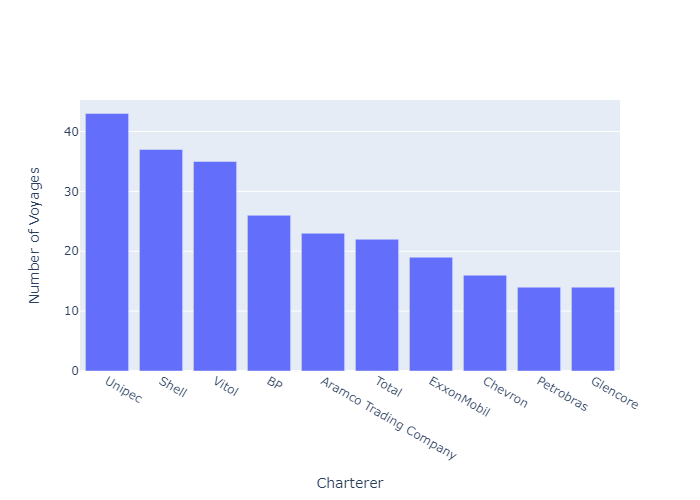

In [16]:
top_chrtr_fig = go.Figure()

bar = go.Bar(
    x=top_chrtr_df.Charterer.tolist(),
    y=top_chrtr_df.FixtureCount.tolist(),
)

top_chrtr_fig.add_trace(bar)
top_chrtr_fig.update_xaxes(title_text="Charterer")
top_chrtr_fig.update_yaxes(title_text="Number of Voyages")
top_chrtr_fig.show()

#### Vessels loading in specific areas

In this example, we will create a visualization, for the number of distinct vessels loading in specific areas per day over the next week

In [17]:
areas = [
    'Arabian Gulf',
    'Continent',
    'US Gulf',
    'Brazil',
    'Korea, Republic of',
]

this_week_days = pd.date_range(start=datetime.utcnow().date(), freq='D', periods=7, tz='UTC')

Create the pivot table

In [18]:
areas_mask = data.load_name.isin(areas) & data.laycan_from.isin(this_week_days)

df_areas = data[areas_mask]

df_pivot = pd.pivot_table(
    df_areas,
    columns='load_name',
    index='laycan_from',
    values='imo',
    aggfunc=pd.Series.nunique,
    fill_value=0,
).reindex(index=this_week_days, fill_value=0).reset_index().rename(columns={'index': 'laycan_from'})

df_pivot

load_name,laycan_from,Arabian Gulf,Brazil,Continent,"Korea, Republic of",US Gulf
0,2022-08-04 00:00:00+00:00,0,0,1,0,9
1,2022-08-05 00:00:00+00:00,1,1,4,4,7
2,2022-08-06 00:00:00+00:00,2,2,3,1,6
3,2022-08-07 00:00:00+00:00,2,0,1,0,12
4,2022-08-08 00:00:00+00:00,9,1,3,1,10
5,2022-08-09 00:00:00+00:00,2,1,0,2,10
6,2022-08-10 00:00:00+00:00,11,0,1,1,7


And display the results as timeseries

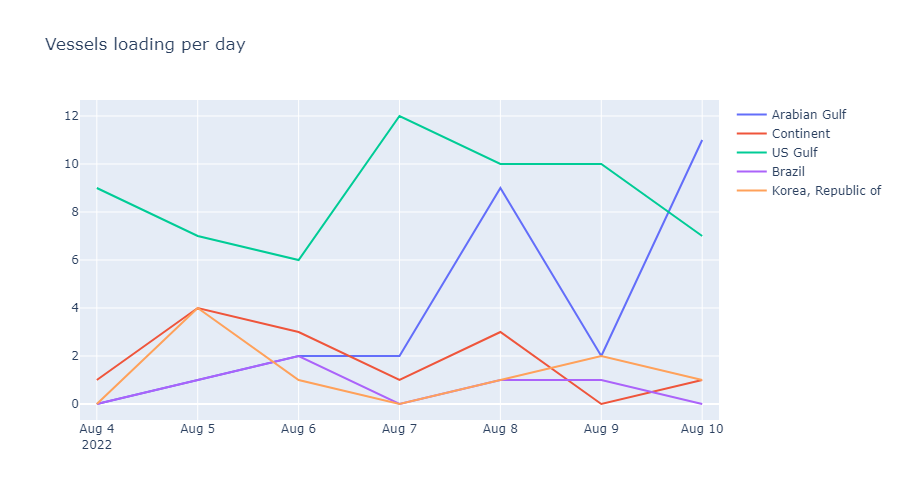

In [19]:
def area_button(area):
    args = [
        {'visible': [i == areas.index(area) for i in range(len(areas))]},
        {
            'title': f'Vessels loading in {area} per day',
            'showlegend': True
        },
    ]
    
    return dict(
        label=area,
        method='update',
        args=args,
    )

title = 'Vessels loading per day'
today = datetime.combine(datetime.utcnow().date(), datetime.min.time())

areas_fig = go.Figure()

area_buttons = []

for area in areas:
    if area not in df_pivot.columns:
        continue
    area_scatter_plot = go.Scatter(    
        x = df_pivot.laycan_from,
        y = df_pivot[area],
        name=area,
        mode='lines',
    )

    areas_fig.add_trace(area_scatter_plot)
    
    area_buttons.append(area_button(area))
    
buttons = list([
    dict(
        label='All',
        method='update',
        args=[    
            {'visible': [True for _ in range(len(areas))]},
            {
                'title': title,
                'showlegend': True
            }
        ],
    ),
    *area_buttons,
])

areas_fig.update_layout(
    title=title,
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=buttons,
    )],
    xaxis_range=[today - timedelta(hours=4), today + timedelta(hours=24*6 + 4)],
)

areas_fig.show()

#### Export data to csv

In [20]:
output_path = '' # Change output_path with your path
filename = 'last_two_days_fixtures.csv'
if not data.empty:
    data.to_csv(output_path+filename, index=False)